## 時間反復法の多項式近似への応用

- 数値計算のアルゴリズム自体は変わらない。実際のコードでもこれまでと異なるのはステップ3の近似のところだけである

- アルゴリズム（再掲）


1. グリッド生成：状態空間の評価点を$I=21$個のグリッドに区切る。また、グリッド上における政策関数$h^{(0)}(k^{i})$の初期値を当て推量(initial guess)する。VFIと異なり、政策関数の収束は必ずしも保証されていないため、初期値はより重要になる

2. 収束の基準：収束の基準になるパラメータ$\varepsilon=10^{-5}$を与える

3. 近似・評価：$k^{i}$上にない政策関数の値については近似する必要がある。$h(k;\mathbb{b})$をパラメータ$\mathbb{b}$を使って近似した時の、$k$上での価値関数の値とする

4. 最適化：古い政策関数$h^{(n-1)}(k^{i})$を所与として、各$k^{i}$について、

$$
  u'(c) = \beta u'(h^{(n-1)}(f(k^{i})-c))f'(f(k^{i})-c)
$$

を$c$について解く。オイラー方程式の解である$c$を探すためには、各言語の最適化関数を利用する。特にTIでは、ここをどう工夫するかで収束のスピードや安定性が変わってくる。このステップで新しい政策関数$h^{(n)}(k^{i})$を得る

5. 全ての$k^{i}$について$\|h^{(0)}(k^{i})-h^{(1)}(k^{i})\|<\varepsilon$であればストップ。そうでなければ、$h^{(1)}(k^{i})$を$h^{(0)}(k^{i})$に代入して、ステップ3-4を繰り返す

- グリッドの数をスプライン補間の場合より少ない$N=3,5,9$個とする。このとき、多項式の次数はそれぞれ$N-1=2,4,8$


- 計算誤差の絶対値の10を底とする対数の平均値と最大値は、低次の多項式ではやや悪化する


- $k$が非常に低い値をとることがありえない場合、グリッドの取り得る値を狭くして、近似誤差が起こりやすい資本の値が少ない場合を避けることで、定次の多項式でも計算誤差を小さくすることができる


- 例えば、$k\in[0.8\bar{k},1.2\bar{k}]$とすると、2次の多項式を使っても、計算誤差は$10^{-3}\sim10^{-4}$程度に収まる

In [1]:
%%file polygrid.m
function k = polygrid(kmin,kmax,N)

    temp = linspace(0,N-1,N)'; %[0:N-1:1]'; % チェビシェフ極値点
    x = -cos((pi/(N-1))*temp);
%     temp = linspace(0,N-1,N)'; %[0:N-1:1]'; % チェビシェフゼロ点
%     x = [0; -cos((pi/2/(N-1))*(2*temp - 1))];
    
    % xからkに変換
    k = 0.5*(kmax-kmin)*(x+1) + kmin;

Created file 'C:\Users\takek\Dropbox\teaching\2021winter\macrotopicsA2021\polygrid.m'.


In [2]:
%%file polybas.m
function T = polybas(kmin,kmax,Np,kgrid)

    % Np: 多項式の次数-1
    % Ng: グリッドの数
    Ng = size(kgrid,1);
    x = (2/(kmax-kmin))*(kgrid-kmin) - 1;
    
    % 基底関数の行列(NgxNp)を再帰的に求める
    T = zeros(Ng,Np);
    T0 = ones(Ng,1);
    T1 = x;
    T2 = 2*x.*T1 - T0;
    T(:,1) = T1;
    T(:,2) = T2;
    
    for i=3:Np-1
        T(:,i) = 2*x.*T(:,i-1) - T(:,i-2);
    end
    
    T = [T0 T(:,1:(Np-1))];

Created file 'C:\Users\takek\Dropbox\teaching\2021winter\macrotopicsA2021\polybas.m'.


In [3]:
%%file EulerEq_cheb.m
function  res = EulerEq_cheb(cons)
% cを与えたときのオイラー方程式の残差を返す関数

global beta gamma alpha delta capital theta kgrid

wealth = capital.^alpha + (1.-delta).*capital;

kprime = wealth - cons;
% トリック: k'は正の値しか取らない
kprime = max(kgrid(1),kprime);

% 次期の政策関数を線形補間
%cnext = interp1(m.kgrid,cfcn,kprime,'linear','extrap');
% 次期の価値関数をスプライン補間
%cnext = interp1(kgrid,cfcn0,kprime,'spline');
% 次期の価値関数を多項式補間
nk = size(kgrid,1);
T = polybas(kgrid(1),kgrid(end),nk,kprime);
cnext = T*theta;

%% オイラー方程式
res = (1/cons) - beta*(1/cnext)*(alpha*kprime.^(alpha-1) + (1.-delta));
 
return

Created file 'C:\Users\takek\Dropbox\teaching\2021winter\macrotopicsA2021\EulerEq_cheb.m'.


In [22]:
clear all;

global beta gamma alpha delta capital theta kgrid

%% *** カリブレーション ***
beta  = 0.96; % 割引因子
gamma = 1.0;  % 相対的危険回避度(異時点間の代替の弾力性の逆数)
alpha = 0.4;  % 資本分配率
delta = 1.00; % 固定資本減耗(delta=1.0のときは解析解が存在)

% 定常状態の値
ykss = (1/beta-1+delta)/alpha;
kss = ykss^(1/(alpha-1));
yss = ykss*kss;
css = yss-delta*kss;

% *** 離散化用のパラメータ ***
nk   = 3;    % グリッドの数
kmax = 0.5; %1.2*kss; %0.5;  % 資本グリッドの最大値
kmin = 0.05; %0.8*kss; %0.05; % 資本グリッドの最小値

In [23]:
% *** 収束の基準 ***
it = 1;          % ループ・カウンター
maxit = 1000;    % 繰り返し計算の最大値
tol  = 1.0e-005; % 許容誤差(STEP 2)
%dif1 = 1;        % 価値関数の繰り返し誤差
dif2 = 1.0;      % 政策関数の繰り返し誤差
count = 1;

%% STEP 1(a): グリッド生成
% kgrid = linspace(kmin, kmax, nk)';
kgrid = polygrid(kmin,kmax,nk);
T = polybas(kmin,kmax,nk,kgrid);
invT = inv(T);

%% STEP 1(b): 政策関数の初期値を設定
cfcn0 = kgrid;
%cfcn0 = m.css/m.kss*m.kgrid; % m.nk=21のときは政策関数の形がおかしい???
%cfcn0 = m.kgrid.^m.alpha - p_true;
%cfcn0 = m.css*ones(nk,1);
cfcn1 = zeros(nk,1);

kgrid(2:end)-kgrid(1:end-1)


ans =

    0.2250
    0.2250




In [24]:
options = optimoptions('fsolve','Display','none'); % fsolveのオプション(最適化の結果を非表示にする)

options.TolFun = 1.0e-10; % fsolveのオプション(最適化の許容誤差)

%% STEP 4: 政策関数を繰り返し計算
while (it < maxit && dif2 > tol)

    fprintf('iteration index: %i \n', it);
    fprintf('policy function iteration error: %e\n', dif2);

    theta = invT*cfcn0;

    for i = 1:nk

        capital = kgrid(i);
        wealth = capital.^alpha + (1.-delta).*capital;

        % MATLABの最適化関数(fsolve)を使って各グリッド上の政策関数の値を探す
        % 最適化の初期値は古い政策関数の値
        cons = fsolve(@EulerEq_cheb,cfcn0(i,1),options);
        cfcn1(i,1) = cons;
        kprime = wealth-cons;
        % グリッドごとに最適化の結果を確認
        %disp([cons capital wealth kprime]);
        %pause

    end

    % 繰り返し計算誤差を確認
    dif2 = max(abs(cfcn1-cfcn0));

    % 収束途中の繰り返し計算誤差を保存
    dif(2,it) = dif2;

    % 政策関数をアップデート
    cfcn0 = cfcn1;

    it = it + 1;

end

iteration index: 1 
policy function iteration error: 1.000000e+00
iteration index: 2 
policy function iteration error: 9.047494e-02
iteration index: 3 
policy function iteration error: 2.820522e-02
iteration index: 4 
policy function iteration error: 1.068586e-02
iteration index: 5 
policy function iteration error: 4.838721e-03
iteration index: 6 
policy function iteration error: 1.941251e-03
iteration index: 7 
policy function iteration error: 7.448687e-04
iteration index: 8 
policy function iteration error: 2.809058e-04
iteration index: 9 
policy function iteration error: 1.052150e-04
iteration index: 10 
policy function iteration error: 3.930226e-05
iteration index: 11 
policy function iteration error: 1.466522e-05



In [25]:
%% 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 = kgrid.^alpha + (1-delta)*kgrid - cfcn0;

%% 解析的解
p_true = beta*alpha*(kgrid.^alpha);


ans =

    0.0412
    0.0141
    0.0027




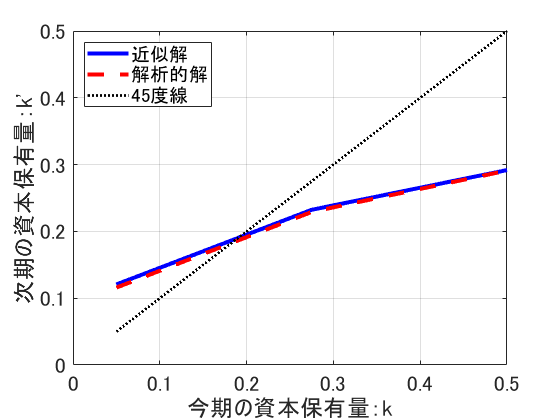

In [29]:
%%
figure;
plot(kgrid, pfcn0, '-', 'Color', 'blue', 'LineWidth', 3);
hold on;
plot(kgrid, p_true, '--', 'Color', 'red', 'LineWidth', 3);
plot(kgrid, kgrid, ':', 'Color', 'black', 'LineWidth', 2);
xlabel('今期の資本保有量：k', 'FontSize', 16);
ylabel("次期の資本保有量：k'", 'FontSize', 16);
%xlim([0 kmax]);
%xticks([0.05 0.1 0.2 0.3 0.4 0.5]);
%xticklabels([0.05 0.1 0.2 0.3 0.4 0.5]);
legend('近似解', '解析的解', '45度線', 'Location', 'NorthWest');
grid on;
set(gca,'FontSize', 16);

pfcn0./p_true-1

In [27]:
%% オイラー方程式から誤差を測定
% 元のグリッドではオイラー方程式の誤差はゼロになるため、グリッドを細かくとる
kgrid_err = linspace(kmin, kmax, (nk-1)*10+1)';
%kgrid_err = kgrid; %linspace(kmin, kmax, (nk-1)*10+1)';
T = polybas(kmin,kmax,nk,kgrid_err);
cons = T*theta;
%cons = interp1(kgrid,cfcn0(:,1),kgrid_err); % 線形補間
LHS  = mu_CRRA(cons, gamma);

kp   = kgrid_err.^alpha + (1-delta)*kgrid_err - cons;
T = polybas(kmin,kmax,nk,kp);
cnext = T*theta;
%cnext = interp1(kgrid, cfcn0(:,1), kp);
rent = alpha.*kp.^(alpha-1.0) - delta;
RHS  = beta.*(1.+rent).*mu_CRRA(cnext,gamma);

err  = RHS./LHS-1.0;

In [28]:

disp(log10([mean(abs(err)) max(abs(err))]))

   -1.3545   -0.9396




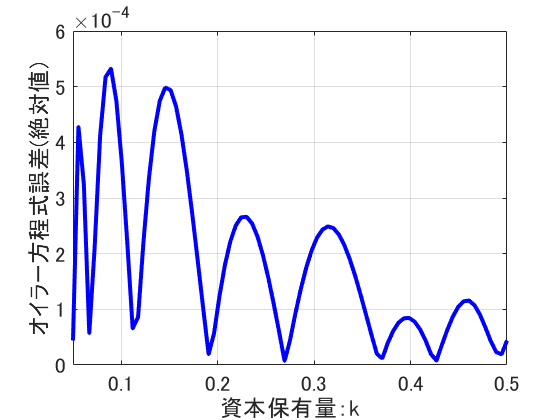

In [20]:
%err2 = csvread("err_ddp.csv");

figure;
plot(kgrid_err, abs(err), '-', 'Color', 'blue', 'LineWidth', 3);
%hold on;
%plot(kgrid_err, abs(err2), '--', 'Color', 'red', 'LineWidth', 3);
xlabel('資本保有量：k', 'FontSize', 16);
ylabel('オイラー方程式誤差(絶対値)', 'FontSize', 16);
xlim([kmin kmax]);
%xticks([0.05 0.1 0.2 0.3 0.4 0.5]);
%xticklabels([0.05 0.1 0.2 0.3 0.4 0.5]);
%legend('TI', 'VFI', 'Location', 'NorthEast');
grid on;
set(gca,'FontSize', 16);